In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output
import collections

In [2]:
with open('t8.shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
raw_text = ' '.join(raw_lines[300:-300])

In [3]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

In [4]:
Dimensions = collections.namedtuple("Dimensions","vocab_size num_neurons, num_steps, batch_size")

dimensions = Dimensions(vocab_size = len(vocab),
                        num_neurons = 500,
                        num_steps = 200,
                        batch_size = 100*128)

In [5]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [6]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

# Graph 

In [7]:
GraphOps = collections.namedtuple("GraphOps","x y learning_rate train prediction init_state state accuracy loss init")

In [8]:
def build_graph(dims):    
    
    tf.reset_default_graph()
    
    #----------input layer-----------------------
    x = tf.placeholder(tf.int64, [None, dims.num_steps],name="x")
    y = tf.placeholder(tf.int64, [None, dims.num_steps],name="y")
    #init_state = tf.placeholder(tf.float32,[None, num_neurons])
    learning_rate = tf.placeholder(tf.float32,[])

    embeddings = tf.get_variable('embedding_matrix', [dims.vocab_size, dims.num_neurons])

    # Tensor of dims batch_size //num_steps x num_steps x num_neurons
    x_transformed = tf.nn.embedding_lookup(embeddings, x)

    #----------hidden layer-----------------------
    cell = tf.nn.rnn_cell.BasicRNNCell(dims.num_neurons)
    init_state = cell.zero_state(dims.batch_size//dims.num_steps,tf.float32)
    rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_transformed, initial_state=init_state, dtype=tf.float32)

    #----------output layer-----------------------
    weight = tf.Variable(tf.truncated_normal([dims.num_neurons, dims.vocab_size], stddev=0.1))
    bias = tf.Variable(tf.constant(0.0, shape=[dims.vocab_size]))

    output = tf.reshape(rnn_output, [-1, dims.num_neurons])
    logits = tf.matmul(output, weight) + bias
    prediction = tf.nn.softmax(logits)
    prediction = tf.reshape(prediction, [-1, dims.num_steps, dims.vocab_size])

    #----------loss and accuracy------------------
    target = tf.reshape(y,[-1])
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 2),y), tf.float32))

    #----------Trainer------------------
    trainOp = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    init_vars = tf.initialize_all_variables()
    
    return GraphOps(x=x, y=y, learning_rate=learning_rate, train=trainOp, prediction=prediction, init_state=init_state, state=final_state, accuracy=accuracy, loss=loss, init=init_vars)


# Training

In [ ]:
print_after_num_steps = 10
adaptive_learning_rate = 0.01
training_state = None

trainHist = []
accHist = []

trainingOps = build_graph(dimensions)

sess = tf.Session()
sess.run(trainingOps.init)

for num_epoch, epoch in enumerate(gen_epochs(raw_text_enc,100,dimensions.batch_size,dimensions.num_steps)):
    
    if num_epoch > 30:
        adaptive_learning_rate = 0.001
    
    for i, batch in enumerate(epoch):
        
        feed_dic = {trainingOps.x: batch[0], trainingOps.y: batch[1], trainingOps.learning_rate: adaptive_learning_rate}
        if training_state is not None:
            feed_dic = {trainingOps.x: batch[0], trainingOps.y: batch[1], trainingOps.learning_rate: adaptive_learning_rate, trainingOps.init_state: training_state}
        acc, lossVal, training_state, _ = sess.run([trainingOps.accuracy, trainingOps.loss, trainingOps.state, trainingOps.train], feed_dict=feed_dic)
        trainHist.append(lossVal)
        accHist.append(acc)
        
        if i % print_after_num_steps == 0:
            clear_output()
            avg_loss = sum(trainHist[-print_after_num_steps:])/print_after_num_steps
            avg_acc = sum(accHist[-print_after_num_steps:])/print_after_num_steps
            logstring = 'Epoch: '+ str(num_epoch) + ' step: ' + str(i) +' loss: ' + str(avg_loss) + ' accuracy: ' + str(avg_acc) + '\n'
            print(logstring)
            with open("log.txt", "a") as myfile:
                myfile.write(logstring)

Epoch: 0 step: 10 loss: 5.37940626144 accuracy: 0.118382813409



In [21]:
saver = tf.train.Saver()
saver.save(sess, 'basic_rnn_save.tf_vars')

'basic_rnn_save.tf_vars'

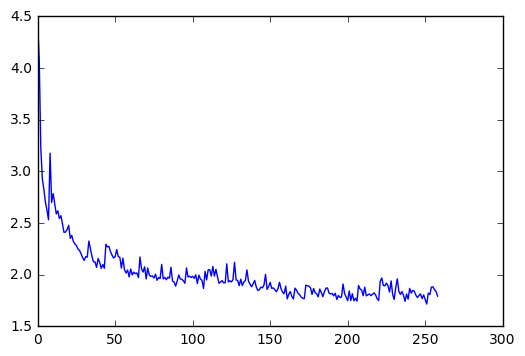

In [23]:
plt.plot(trainHist[:])

In [25]:
#rebuild the graph:
gen_dimensions = Dimensions(vocab_size = dimensions.vocab_size, 
                            num_neurons = dimensions.num_neurons, 
                            num_steps = 1,
                            batch_size = 1)

gen_ops = build_graph(gen_dimensions)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

saver = tf.train.Saver()
saver.restore(sess, 'basic_rnn_save.tf_vars')

prev = np.array([[trans_dic['x']]])

digital_shakespeare = ''
pred_hist = []

for i in range(1000):
    if i == 0:
        pred, state = sess.run([gen_ops.prediction,gen_ops.state],feed_dict={gen_ops.x: prev})
    else:
        pred, state = sess.run([gen_ops.prediction,gen_ops.state],feed_dict={gen_ops.x: prev, gen_ops.init_state: state})
    
    pred_hist.append(pred)
    prev = rev_trans_dic[np.random.choice(gen_dimensions.vocab_size,1,p=np.squeeze(pred)).flatten()[0]]
    digital_shakespeare += prev
    prev = np.array([[trans_dic[prev]]])

In [26]:
print(digital_shakespeare)

bying the at.
 
     Evas
        Lexuzy slyeld nace did!
   ANEROCTEANONG I Shalk well core goo in in the love should, of forvite this fisseil; I parus
     Bewnaren emossed apsell not dain
     I will good cing my sioble this,
     Whath surow weach her by place, in to deecking in fane; thy surgure, and a spifcher starder seey fent, betrives.
   KINTOVIA. He
   Dell mote to reand, but thind and in habet distary my laig ded to say begest, ICabe this I faffiise herrain
     Whered pyuce, that I moschbes'daned           
     Whichacwar tell.
 BOSSOSTE wayig's the marm. That
   SUKING Bust
     Than a therefow provetref two my choold gome-fabassante;
   The figen Mod greelotion ory my Mait fasten
     What in a beargedous, and to say your and Bencesg.  me.
   ANEANINORLERARLERES
     poury trunger you a wristuss., then good me thand hangs other: a not myabbisharrich.
     Jinos be aselfise;
                       Selline's therost tand in
     To be, fewfill a's plearon eparceant the th